# ANITA astroinformatics summer school 2019 - "Rise of the machines"

## Part II - Classification

This notebook provides an introduction to machine learning and walks through how to develop workflows for training machine learning models.

This lesson is prepared by:
- [Kevin Chai](http://computation.curtin.edu.au/about/computational-specialists/health-sciences/)
- [Rebecca Lange](http://computation.curtin.edu.au/about/computational-specialists/humanities/)

from the [Curtin Institute for Computation](http://computation.curtin.edu.au) at Curtin University in Perth, Australia. 

Some of the materials in this notebook have been referenced and adapted from:
- [Randal Olsen's Data Science Notebook](https://github.com/rhiever/Data-Analysis-and-Machine-Learning-Projects/tree/master/example-data-science-notebook)
- [Sebastian Raschka's Python Machine Learning Notebooks](https://github.com/rasbt/python-machine-learning-book)
- [Kevin Markham's Scikit Learn Notebooks](https://github.com/justmarkham/scikit-learn-videos)

Make sure to open this notebook in the root directory of the code repository.

This work is made available under the [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).

## Table of contents

1. [Introduction](#1.-Introduction)
2. [Problem definition](#2.-Problem definition)
3. [Data preparation](#3.-Data-preparation)
4. [Classification](#4.-Classification)

## 1. Introduction

### Required libraries

[[ go back to the top ]](#Table-of-contents)

This notebook uses several Python packages that come standard with the [Anaconda Python distribution](http://continuum.io/downloads). The primary libraries that we'll be using are:

* **NumPy**: a fast numerical array structure and helper functions.
* **pandas**: a DataFrame structure to store data in memory and work with it easily and efficiently.
* **scikit-learn**: a machine learning package.
* **matplotlib**: a basic plotting library; most other plotting libraries are built on top of it.
* **seaborn**: a advanced statistical plotting library.

To make sure you have all of the packages you need, install them with `conda`:

    conda install numpy pandas scikit-learn matplotlib seaborn

`conda` may ask you to update some of the packages if you don't have the most recent version. Allow it to do so.

Alternatively, if you can install the packages with [pip](https://pip.pypa.io/en/stable/installing/) (a Python package manager):

    pip install numpy pandas scikit-learn matplotlib seaborn


### Machine learning

[[ go back to the top ]](#Table-of-contents)

Machine learning refers to algorithms that learn from examples and experiences (data). These algorithms often perform better than explicitly hard coded rules for complex tasks. i.e. where it is difficult to describe precise rules.

We will explore two types of machine learning algorithms in this notebook:

**1. Supervised Learning** 
* make predictions using data
* There is an outcome we are trying to predict
* Example: Is an e-mail spam or ham?

![Spam filter](../media/spam_filter.png)
<div style="text-align:center;font-weight:bold">Figure: Classification example</div>

The workflow for developing and deploying a supervised machine learning model is shown below.

![Supervised Learning Workflow](../media/supervised_learning_workflow.jpg)
<div style="text-align:center;font-weight:bold">Figure: Supervised learning workflow</div>

**2. Unsupervised Learning**
* Extract structure from data
* There is no "right answer"
* Example: Segment grocery store shoppers into clusters that exhibit similar behaviours

![Clustering](../media/clustering.png)
<div style="text-align:center;font-weight:bold">Figure: Clustering example</div>

The unsupervised learning workflow is illustrated in  the figure below. Observe that no labels are used for training. 

![Unsupervised Learning Workflow](../media/unsupervised_learning_workflow.png)

## 2. Problem definition

### Domain

[[ go back to the top ]](#Table-of-contents)

We have been tasked to develop a machine learning model to classify galaxies by their morphology (appearance) from a dataset containing measurements such as:

- redshift
- magnitude in _ugriz_ bands
- exponential scale radius and ellipticity
- de Vaucouleurs scale radius and ellipticity
- stellar mass
- ...
- etc.

Galaxies in the dataset have labels taken from [Galaxy Zoo](https://www.galaxyzoo.org/) DR1 - Table 2. Galaxy Zoo is described in Lintott et al. 2008, MNRAS, 389, 1179 and the data release is described in Lintott et al. 2011, 410, 166. 

We use the final debiased labels to categorise a galaxy as:

- spiral
- elliptical

![Galaxies](../media/spiral_ellipse_galaxies.jpg)

<div style="text-align:center;font-weight:bold">Figure: A spiral galaxy (left) and elliptical galaxy (right)</div>

Our goal is to train a model that can accurately classify galaxies. We want our model to generalise well. i.e. it can correctly classify unseen galaxies (i.e. galaxies not in our training dataset).

### Definition

[[ go back to the top ]](#Table-of-contents)

The first step of developing a machine learning model is to clearly understand and define the problem we want to solve. Here are some useful questions to ask. 

#### Does the dataset contain labels?

Yes, the dataset contains galaxy morphology labels (spiral and elliptical). Therefore, we can use supervised learning methods to utilise the labelled data.

#### What is the type of problem?

We want to classify galaxies by their morphology so this is a classification problem.

#### What metric can be used to evaluate the model?

Since we are performing classification, we can use a classification metric such as [accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision) to evaluate and quantify the performance of our model. Accuracy is the percentage of correctly classified galaxies. As a challenge, we have been asked to develop a model that achieves ≥ 70% accuracy. Is this feasible? How can we find out?

#### Can the question actually be answered with the available data?

Yes, the dataset contains labels of the galaxy types we want to classify. i.e. `{spiral, elliptical}`. If we were asked to develop a model to detect other types of galaxies then we would need to collect data and labels for these other types.

#### Are there problem and application requirements we need to consider?

How will the model be used after it has been developed? Are there requirements for the model to be used on specific devices? e.g. personal computers, smart phones, embedded systems and/or servers. For the purpose of this lesson, we can assume that it is fine to train and run the model on our personal computers. However, this may not always be the case and it is something to consider if we are required to deploy our models to systems with limited compute and memory resources (e.g. embedded systems). In these instances, we may be restricted to build small, less complex and fast models at the cost of reduced performance (e.g. accuracy).

<hr />

**Thinking about and documenting the problem we're working on is an important step to performing effective machine learning (and data analysis in general) that sometimes gets overlooked.**

### Dataset

[[ go back to the top ]](#Table-of-contents)


**See "Part I - data prep and exploration" for details on the data cleaning and exploration process.**


For this lesson, we will be using data from [Galaxy Zoo DR1](https://www.galaxyzoo.org/) and the Sloan Digital Sky Survey (SDSS) ([using the DR9 SQL search](http://skyserver.sdss.org/dr9/en/tools/search/sql.asp)). 

The data dictionary for this dataset is presented in Table 1. This dataset is limited to the first 5,000 Galaxy Zoo classified galaxies which have spectra in the SDSS database. The debiased fraction of the votes in elliptical and spiral categories is given, along with columns identifying systems classified as spiral, elliptical or uncertain.

<p style="text-align:center;font-weight:bold">Table 1: Data dictionary</p>

| Column           | Description                                                            |
|:-----------------|:-----------------------------------------------------------------------|
| id               | unique SDSS ID composed of [skyVersion, rerun, run, camcol, field, obj]|
| ra               | right ascension  (HMS)                                                 |
| dec              | declination (DMS)                                                      |
| redshift         | redshift                                                               |
| mag_u            | magnitude _u_ band                                                     |
| mag_g            | magnitude _g_ band                                                     |
| mag_r            | magnitude _r_ band                                                     |
| mag_i            | magnitude _i_ band                                                     |
| mag_z            | magnitude _z_ band                                                     |
| deVRad_r         | de Vaucouleurs scale radius fit in _r_ band                            |
| deVAB_r          | ellipticity from de Vaucouleurs fit in _r_ band                        |
| expRad_r         | exponential scale radius fit in _r_ band                               |
| expAB_r          | ellipticity from exponential fit in _r_ band                           |
| stellar_mass     | log galaxy mass (in units of solar mass)                               |
| votes            | number of Galaxy Zoo annotators                                        |
| p_el_debiased    | debiased labelling probability the galaxy is elliptical                |
| p_cs_debiased    | debiased labelling probability the galaxy is spiral                    |
| spiral           | label = spiral galaxy {0=False, 1=True}                                |
| elliptical       | label = elliptical galaxy {0=False, 1=True}                            |
| uncertain        | label = uncertain {0=False, 1=True}                                    |





In [2]:
import os
os.getcwd()

'/Users/268964i/Documents/REPOSITORIES/ADACS-ANITA-school-2019/notebooks'

In [1]:
import numpy as np
import pandas as pd

# Load the clean dataset
df = pd.read_csv('data/galaxies-clean.csv')
df.describe()

,id,redshift,mag_u,mag_g,mag_r,mag_i,mag_z,deVRad_r,deVAB_r,expRad_r,expAB_r,stellar_mass,class
count,1.797000e+03,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000
mean,5.883237e+17,0.102410,19.152020,17.522870,16.692434,16.288154,15.996882,6.463833,0.556183,3.117289,0.572626,10.709025,0.753478
std,5.601681e+14,0.048564,1.055642,0.912204,0.843307,0.831556,0.837130,4.961947,0.241977,1.971871,0.228428,0.530440,0.431106
min,5.877230e+17,0.012020,14.966660,13.255867,12.495058,12.070313,11.729467,0.318959,0.078741,0.388597,0.104792,8.096545,0.000000
25%,5.877289e+17,0.071303,18.517124,17.035631,16.309929,15.890931,15.592772,3.015255,0.340447,1.849088,0.372516,10.419759,1.000000
50%,5.888489e+17,0.095218,19.224937,17.689970,16.908895,16.501181,16.201313,5.115593,0.565291,2.617536,0.575910,10.749136,1.000000
75%,5.888489e+17,0.126174,19.858212,18.187084,17.315275,16.890751,16.597639,8.243093,0.766777,3.850953,0.775527,11.054677,1.000000
max,5.888489e+17,0.323238,24.691055,20.303535,19.109604,18.516237,18.302301,29.673195,0.999966,20.043400,0.999905,11.979653,1.000000


The summary table provides some useful information:

- there are 1,797 galaxies in our dataset
- the mean of the `class` column indicates that ~75.3% of the dataset are spiral galaxies
- min values for the radius columns range from 0.31 to 0.38
- min value for the `stellar_mass` = 8.096
- min value for the `mag` ranging from 15.59 to 18.5

Our cleaned dataset contains 1,797 galaxies and 75.3% of the records are spiral galaxies.

---

For completeness, let's generate a scatterplot for all features in one figure.

/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


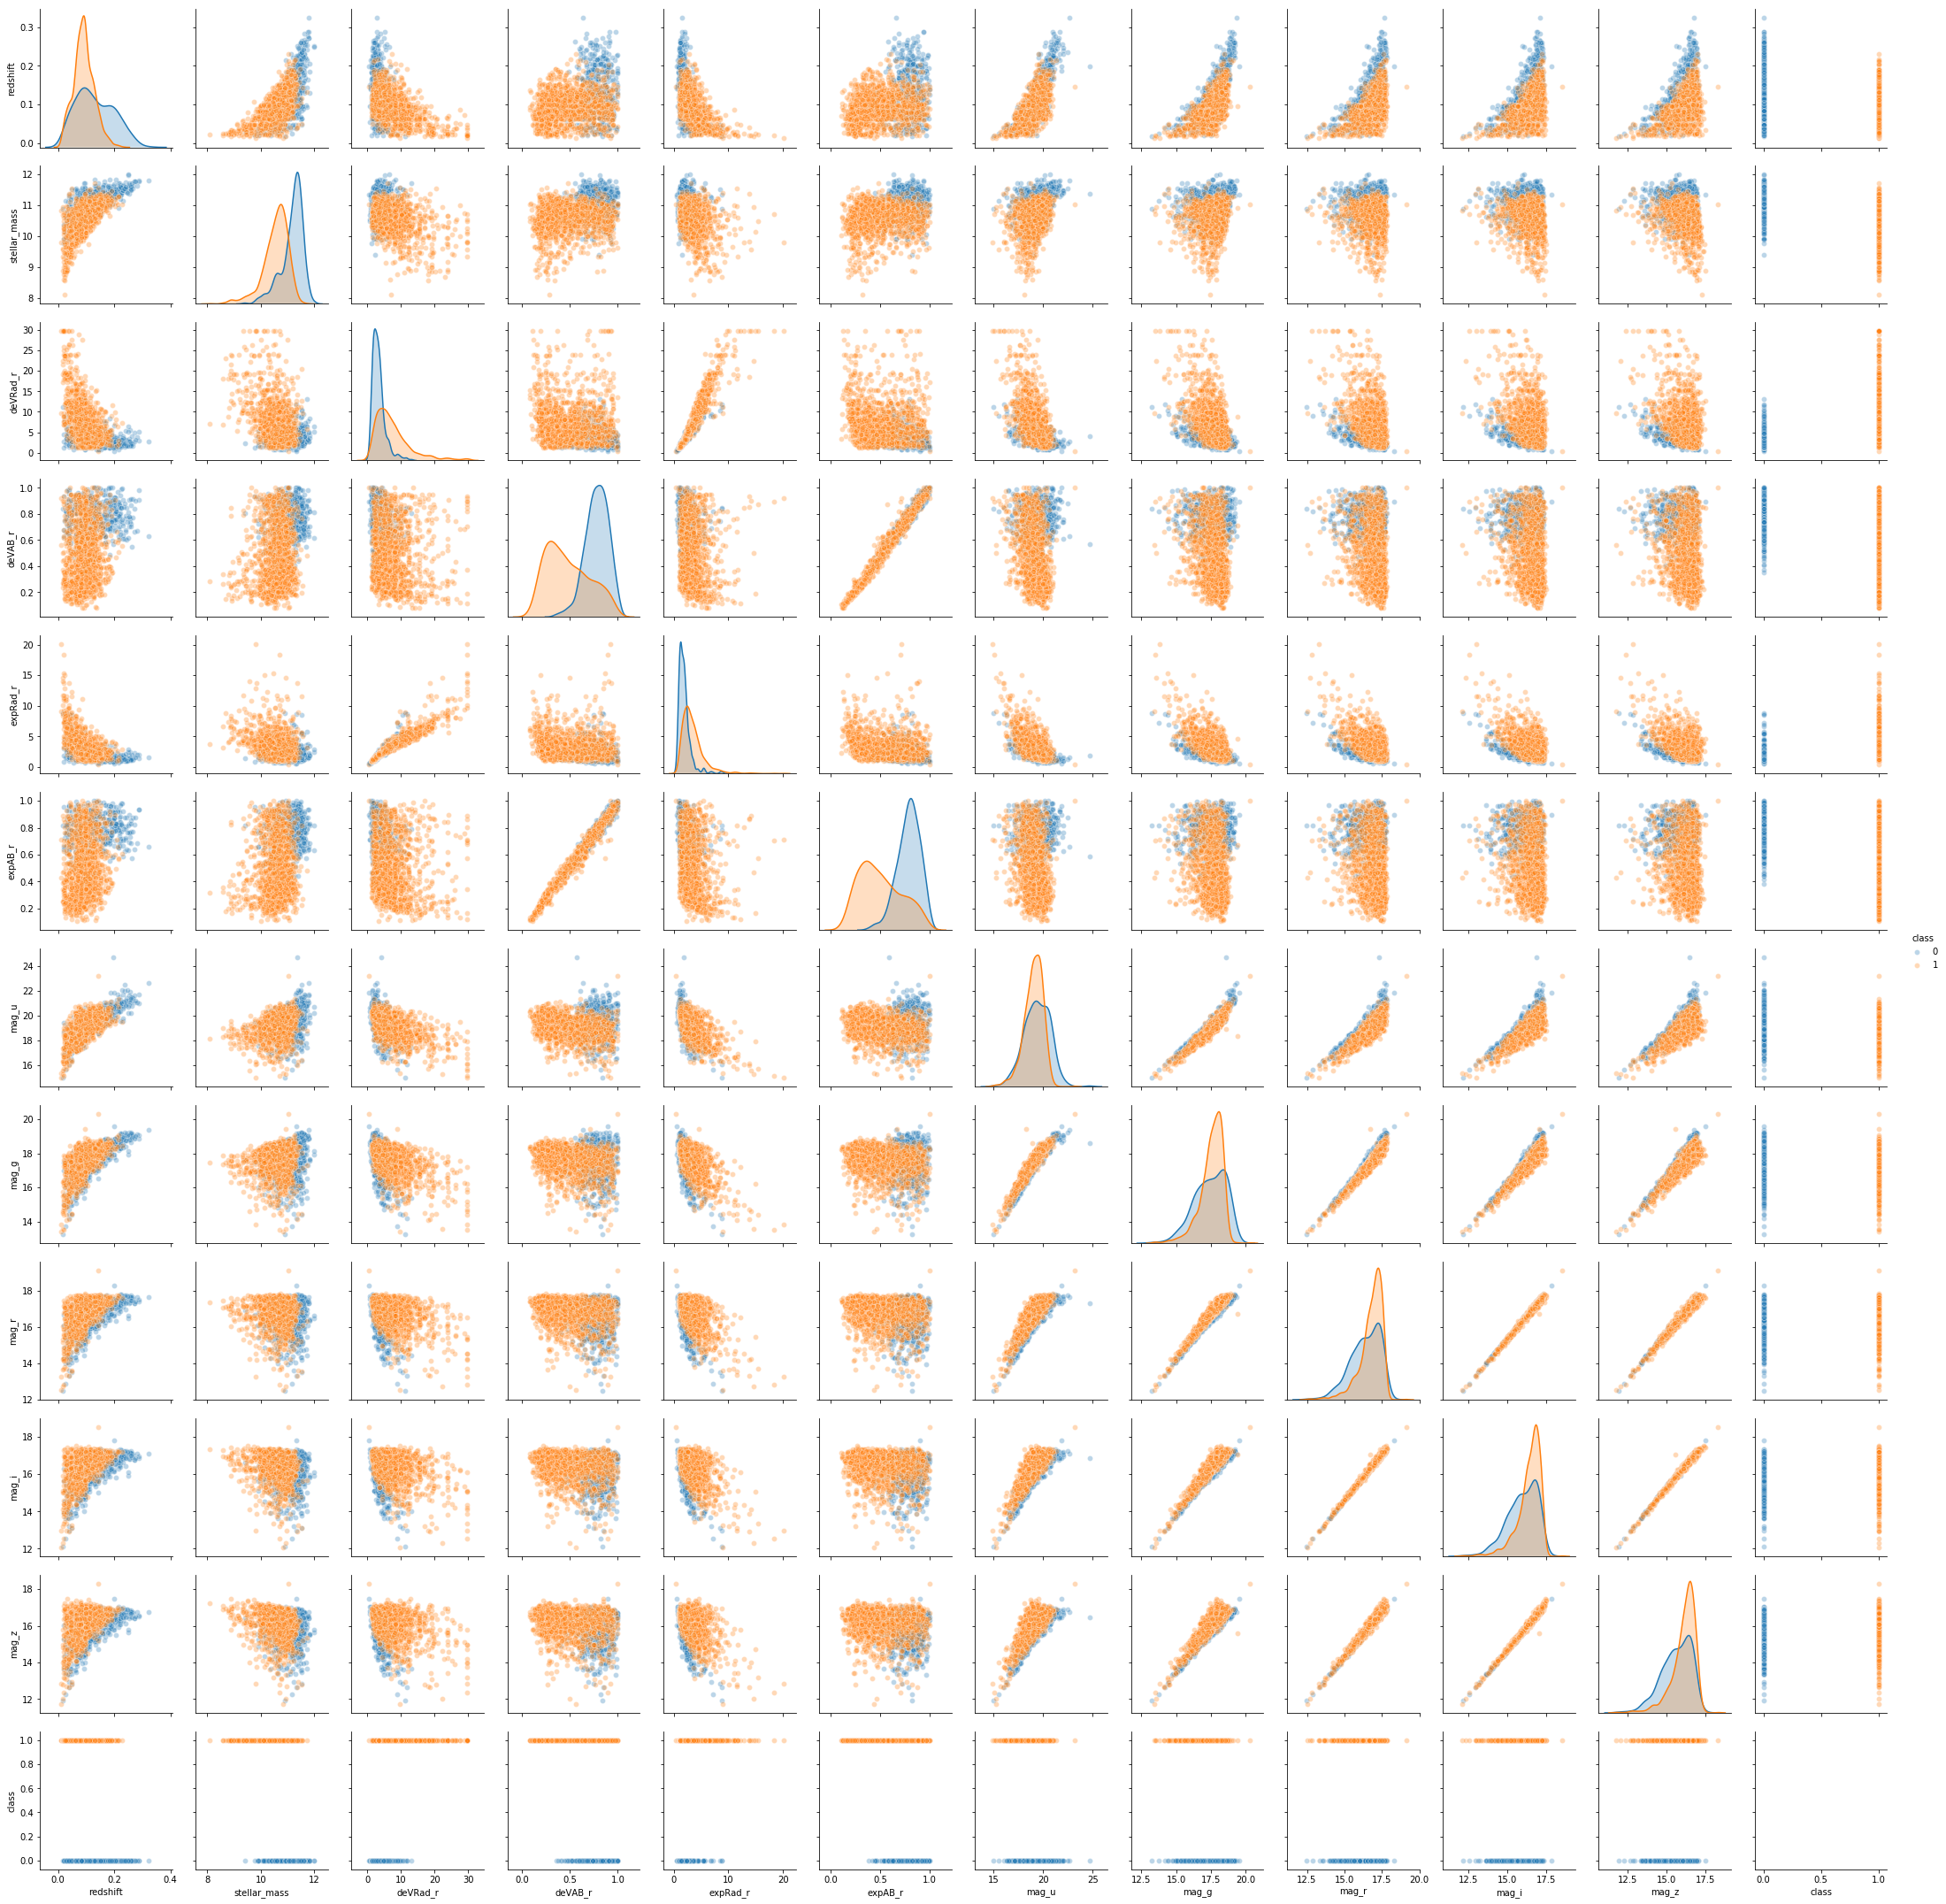

In [2]:
# Command to show plots inside of the notebook
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sb

magnitudes = ['mag_u', 'mag_g', 'mag_r', 'mag_i', 'mag_z']
measurements = ['redshift', 'stellar_mass', 'deVRad_r', 'deVAB_r', 'expRad_r', 'expAB_r']


# Plot scatterplot matrix with all features
selected_columns = measurements + magnitudes + ['class']
sb.pairplot(df[selected_columns], hue='class', plot_kws={'alpha': 0.3})

## 3. Data preparation

[[ go back to the top ]](#Table-of-contents)

Cleaning and exploring the data is a important component to any machine learning project. If we had jumped straight in to modelling, we would have trained a model with errors in the dataset. **Bad data leads to bad models.**

Now it's a good time to introduce some machine learning terminology.

### Terminology

- Each row is an `example` (also known as (aka): observation, sample, instance, record)
- Each column is a `feature` (aka: predictor, attribute, dimension, independent variable)
- The value we are predicting is the `label` (aka: target, outcome, dependent variable) 

In classification, the label is also referred to as the class or category.

### Notation

Let:
- `m` = the number of examples in our dataset
- `n` = the number of features in our dataset

The dataset can be represented by two variables as shown in Table 2:

1. A matrix `X` containing the examples and features of size `m x n`
2. A vector `y` containing the labels of size `m`

<p style="text-align:center;font-weight:bold">Table 2: Dataset notations</p>

<table>
    <thead>
        <tr>
            <th style="text-align:center" colspan=3>X</th>
            <th style="text-align:center">y</th>
        </tr>
        <tr>
            <th style="text-align:center">feature 1 ($x_1$)</th>
            <th style="text-align:center">feature 2 ($x_2$)</th>
            <th style="text-align:center">feature 3 ($x_3$)</th>
            <th style="text-align:center">label</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td style="text-align:center">5</td>
            <td style="text-align:center">12</td>
            <td style="text-align:center">3</td>
            <td style="text-align:center">0</td>
        </tr>
        <tr>
            <td style="text-align:center">1</td>
            <td style="text-align:center">3</td>
            <td style="text-align:center">8</td>
            <td style="text-align:center">1</td>
        </tr>
        <tr>
            <td style="text-align:center">9</td>
            <td style="text-align:center">3</td>
            <td style="text-align:center">2</td>
            <td style="text-align:center">1</td>
        </tr>
        <tr>
            <td style="text-align:center">5</td>
            <td style="text-align:center">8</td>
            <td style="text-align:center">7</td>
            <td style="text-align:center">0</td>
        </tr>
        <tr>
            <td style="text-align:center">2</td>
            <td style="text-align:center">7</td>
            <td style="text-align:center">8</td>
            <td style="text-align:center">0</td>
        </tr>
    </tbody>
</table>

This is the standard notation used in machine learning. Following this convention makes it easier for other machine learning practitioners to understand your scripts. This notation also allows us to concisely define supervised machine learning and classification described in the [Introduction](#1.-Introduction) section.

#### Supervised learning
Learn a function `f` that maps features to labels
<p style="text-align:center;font-weight:bold">$f(X) \rightarrow y$</p>

\begin{align}
y &= \begin{bmatrix}
    y_1 \\
    \vdots \\
    y_i \\
    \vdots \\
    y_{m}
    \end{bmatrix}
\end{align}

With classification, $y_i = \{c_1, ..., c_k\},where\ k = number\ of\ classes$

We only have two classes in our dataset so $y_i \in \{0=elliptical, 1=spiral\}$

### Scikit Learn
We will be using the [scikit-learn](http://scikit-learn.org/) machine learning library for developing our models. As such, we need to prepare our dataset into a format that scikit-learn expects:

1. Features and labels are **separate objects**
2. Features and labels should be **numeric**
3. Features and labels should be **`numpy` arrays**
4. Features and labels should have **specific shapes**

**Note**: `pandas` is built on top of `numpy` so we can create the features matrix as a pandas `DataFrame` and labels vector as a pandas `Series`.

Let's prepare the dataset for scikit-learn.

In [3]:
# Import the required libraries
import numpy as np
import pandas as pd

# Set a random seed number to repoduce our results
seed = 19

# Load the clean dataset
df = pd.read_csv('data/galaxies-clean.csv')

# Selected columns for modelling
measurements = ['redshift','stellar_mass','deVRad_r','deVAB_r','expRad_r','expAB_r']
magnitudes = ['mag_u','mag_g','mag_r','mag_i','mag_z']
features = measurements + magnitudes

# features matrix
X = df[features]

# labels vector
y = df['class']

Let's verify our features matrix and labels vector

In [4]:
# Features matrix
# expected output: pandas DataFrame, (number of rows, number of features)
print('X: %s, %s' % (type(X), X.shape))

# Labels vector 
# expected output: pandas Series, (number of rows,)
print('y: %s, %s' % (type(y), y.shape))

X: <class 'pandas.core.frame.DataFrame'>, (1797, 11)
y: <class 'pandas.core.series.Series'>, (1797,)


That looks great. Now we can start modelling.

## 4. Classification

[[ go back to the top ]](#Table-of-contents)

### Splitting the data

It's time to make the next big step in our analysis: splitting the data into training and test sets.

- A **training set** is a random subset of the data that we use to train our models.
- A **test set** is a random subset of the data (mutually exclusive from the training set) that we use to test our models.

In machine learning we are always concerned that our models will **overfit** the data. i.e. The model learns the training set so well that it won't be able to handle examples it's never seen before. This is why it's important for us to build the model with the training set, but score it with a separate unseen testing set.

Once we split the data into a training and test set, we should treat the test set like it no longer exists. We cannot use any information from the testing set to build our model or else we're cheating. The training dataset can also be split again to create a validation set to tune our models. It is important that the validation set is separate from the holdout test dataset.

This process is illustrated in the figure below.

<div style="text-align:center;font-weight:bold">Figure: Holdout set method to split the dataset</div>
<img src="../media/holdout.png" />



Now let's split the dataset using the `train_test_split` function.

In [5]:
# Import the train_test_split function
from sklearn.model_selection import train_test_split

# Split the dataset into 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=seed)


/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


With the dataset split, we can start fitting models to our data. We have heard from our colleagues that they have had success using decision tree classifiers in their projects so let's start with those.

**Decision tree** classifiers are incredibly simple in theory. In their simplest form, decision tree classifiers ask a series of Yes/No questions about the data — each time getting closer to finding out the class of each example — until they either classify the data set perfectly or simply can't differentiate a set of examples.

An example decision tree classifier for approving loan applications is shown in the following figure.

<div style="text-align:center;font-weight:bold">Figure: Decision tree example</div>
<img src="../media/decision_tree_example.png" />

Notice how the classifier asks yes/no questions about the data. e.g. whether the applicant owns a house so it can differentiate the records. 

**check the slides for a walk-through of how the decision tree works**

Decision tree classifiers are *scale-invariant*, i.e. the scale of the features does not affect their performance unlike many machine learning models. In other words, it doesn't matter if our features range from 0 to 1 or 0 to 1,000; decision tree classifiers will work with them just the same.

There are several [parameters](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) that we can tune for decision tree classifiers and different [metrics](https://en.wikipedia.org/wiki/Evaluation_of_binary_classifiers) we can use to evaluate its performance. For now let's use a basic decision tree and the accuracy performance metric.

\begin{align}
accuracy &= \dfrac{correct\ classifications}{total\ number\ of\ classifications}
\end{align}

Scikit learn provides a 4 step modelling pattern which makes it easy to switch in different models / algorithms for your dataset. This pattern is described in the code and comments below. 

In [7]:
# Step 1: Import the model
from sklearn.tree import DecisionTreeClassifier

# Step 2: Instantiate the model
dtc = DecisionTreeClassifier(random_state = seed)

# Step 3: Fit the model on data (i.e. train the model)
dtc.fit(X_train, y_train)

# Step 4: Generate predictions / scores
dtc.score(X_test, y_test)

0.9138888888888889

That's great! Our model achieves 91% accuracy without much effort. We have already beaten the challenge to build a model with ≥ 70% accuracy.

However, there's a catch. Depending on how our training and testing set is sampled, our model can achieve anywhere from 87% to 96% accuracy.

/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_sp

/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_sp

/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_sp

/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_sp

/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_sp

/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_sp

/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_sp

/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_sp

/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_sp

/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_sp

/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_sp

/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_sp

/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_sp

/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_sp

/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_sp

/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_sp

/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_sp

/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_sp

/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_sp

/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)
/Users/268964i/anaconda3/envs/deepml/lib/python3.6/site-packages/sklearn/model_selection/_sp

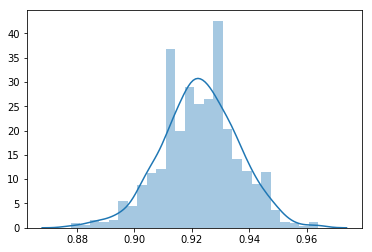

In [8]:
model_accuracies = []

# Split the dataset differently and fit a model on this split, 1,000 times
for i in range(1000):
    X2_train, X2_test, y2_train, y2_test = train_test_split(X, y, train_size=0.8, random_state=i)
    
    decision_tree_classifier = DecisionTreeClassifier(random_state=seed)
    decision_tree_classifier.fit(X2_train, y2_train)
    classifier_accuracy = decision_tree_classifier.score(X2_test, y2_test)
    model_accuracies.append(classifier_accuracy)



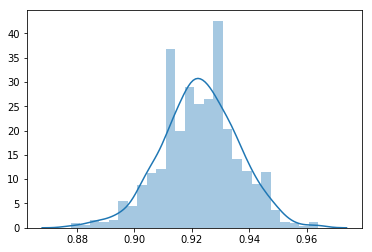

In [9]:
sb.distplot(model_accuracies)

This is a problem! The model performance varies a lot depending on the subset of the data it's trained on. This means the model is **overfitting**: the model learns to classify the training set so well that it doesn't generalize and perform well on data it hasn't seen before (i.e. the test set).

### Cross-validation

[[ go back to the top ]](#Table-of-contents)

Cross validation is a method of splitting the dataset to help address this problem. For this lesson, we will use the ***k*-fold cross-validation** method. This involves splitting the original data set into *k* subsets, use one of the subsets as the testing set and, the rest of the subsets are used as the training set. This process is repeated *k* times such that each subset is used as the testing set exactly once. This process is illustrated in Figure X.

<div style="text-align:center;font-weight:bold">Figure: k-fold cross-validation</div>
<img src="../media/k-fold.png" />

10-fold cross-validation is the most common choice so let's use that here. Performing 10-fold cross-validation on our data set looks something like this on a subset of 100 examples in our dataset.

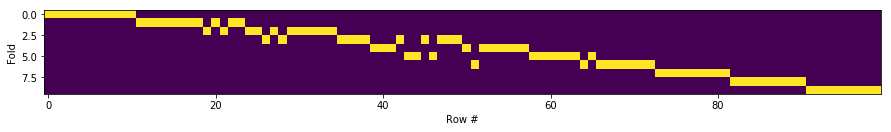

In [10]:
def plot_cv(cv, n_samples):
    masks = []
    for train, test in cv:
        mask = np.zeros(n_samples, dtype=bool)
        mask[test] = 1
        masks.append(mask)
        
    plt.figure(figsize=(15, 15))
    plt.imshow(masks, interpolation='none')
    plt.ylabel('Fold')
    plt.xlabel('Row #')
    
# Import the function
from sklearn.model_selection import StratifiedKFold

# Use a subset of 100 examples
subset_y = y[0:100]
subset_x = X[0:100]

skf = StratifiedKFold(n_splits=10)

# Plot the data split
plot_cv(skf.split(subset_x, subset_y), len(subset_y))

Each square in the plot represents an example in our dataset.

You'll notice that we used the `StratifiedKFold` function in the code above. Stratified means we keep the class percentage the same across all of the folds (~75% spiral), which is important for maintaining a representative subset of our dataset. i.e. we don't want to end up having 100% spiral galaxies in one of the folds.

We can fit a decision tree classifier using 10-fold cross-validation with the `cross_val_score` function.

Text(0.5, 1.0, 'Average score: 0.9213424193177714')

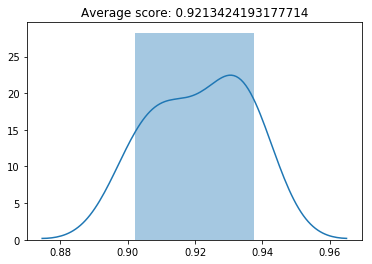

In [11]:
# Import the cross_val_score function
from sklearn.model_selection import cross_val_score

# Create a decision tree classifier
dtc = DecisionTreeClassifier(random_state = seed)

# cross_val_score returns a list of the scores, which we can visualize
# to get a reasonable estimate of our classifier's performance
cv_scores = cross_val_score(dtc, X_train, y_train, cv =10)

# Plot the results
sb.distplot(cv_scores)
plt.title('Average score: {}'.format(np.mean(cv_scores)))

That looks much better. We have a more consistent score (less variance) of our model's classification accuracy.

### Learning curves

[[ go back to the top ]](#Table-of-contents)

Learning curves allow us to evaluate the performance of our models as they are provided more training examples. i.e. They show us how or if our model learns. Plotting these curves also allows us to diagnose our models in order to gain insights on how we can improve them. More specifically, learning curves allows us to identify:

- underfitting (high bias): model performs poorly on training and validation
    - Try more features
    - Decrease regularisation
- overfitting (high variance): model performance is good on training but much poorer on validation
    - Get more data
    - Use less features
    - Increase regularisation

Ideally, we want to develop a model that achieves similar performance on both the training and validation sets (good bias and variance trade off) as shown in the figure below.

<div style="text-align:center;font-weight:bold">Figure: Learning curves</div>
<img src="../media/learning_curves.png" />

_Source: Andrew Ng, Coursera - Machine Learning. 2012_

Let's plot the learning curve for our decision tree classifier using the `learning_curve` function.

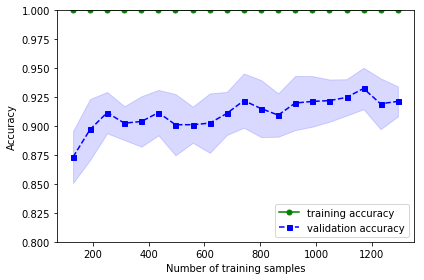

In [12]:
# Import the learning_curve function
from sklearn.model_selection import learning_curve

# Create a decision tree classifier
dtc = DecisionTreeClassifier(random_state=seed)
# Generate the learning curve scores 
train_sizes, train_scores, val_scores = learning_curve(estimator = dtc,
                                                      X = X_train,
                                                      y = y_train,
                                                      train_sizes = np.linspace(0.1,1.0,20),
                                                      cv = 10,
                                                      n_jobs = 1)

# Calculate the result averages and standard deviatio
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Plot the training learning curve
plt.plot(train_sizes, train_mean,
         color='green', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='green')

# Plot the validation learning curve
plt.plot(train_sizes, val_mean,
         color='blue', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 val_mean + val_std,
                 val_mean - val_std,
                 alpha=0.15, color='blue')

# Plot settings
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1])
plt.tight_layout()
# plt.savefig('images/learning_curve.png', dpi=300)
plt.show()

From the learning curve we can see that the decision tree classifier overfits the training dataset. The training accuracy remains constant at 100% (fits the data perfectly) while the average validation scores steadily increase from 87% to 93% as the number of training samples increases.

Now that we know our decision tree classifier overfits the dataset, let's do something about it!

### Parameter tuning

[[ go back to the top ]](#Table-of-contents)

Every machine learning model comes with a variety of parameters to tune, and these parameters can be vitally important to the performance of our classifier. For example, using the default parameters for decision trees has resulted in our classifier overfitting the training dataset. 

As an extreme example, let's limit the depth of our decision tree classifier to a `max_depth = 1`:

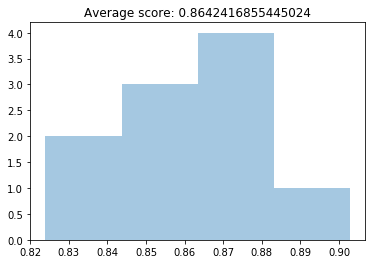

In [13]:
# Set the max_depth of the decision tree to 1
dtc = DecisionTreeClassifier(max_depth=1, random_state=seed)

# Calculate the cross validation score
cv_scores = cross_val_score(dtc, X_train, y_train, cv=10)

# Plot the results
sb.distplot(cv_scores, kde=False)
plt.title('Average score: {}'.format(np.mean(cv_scores)))
plt.show()

The average classification accuracy has dropped to 86%.

We need to use a systematic method to discover the best parameters for our model and dataset.

#### Grid search

A common method for model parameter (hyperparameter) tuning is grid search. The idea behind grid search is to explore a range of parameters and find the best-performing parameter combination. Focus your search on the best range of parameters, then repeat this process several times until the best parameters are discovered.

Let's tune our decision tree classifier using the `GridSearchCV` function. We'll stick to only two parameters for now (`max_depth` and `max_features`), but it's possible to simultaneously explore dozens of parameters if we want.

In [14]:
# Import the GridSearchCV function
from sklearn.model_selection import GridSearchCV

# Create a decision tree classifier
dtc = DecisionTreeClassifier(random_state=seed)

# Parameter values to explore
parameter_grid = {'max_depth':[1,2,3,4,5,6],
                 'max_features':[7,8,9,10,11]}

# Create a cross validation object using StratifiedKFold
skf = StratifiedKFold(n_splits=10, random_state=seed)
cross_validation = skf.split(X_train, y_train)

# Instantiate the grid search using GridSearchCV
grid_search = GridSearchCV(dtc,
                          param_grid = parameter_grid,
                          cv = cross_validation)

# Fit the decision tree using grid search

grid_search.fit(X_train, y_train)

# Display the results
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.9283228949199722
Best parameters: {'max_depth': 6, 'max_features': 9}


We can also visualize the grid search to see how the parameters interact.

Text(33.0, 0.5, 'max_depth')

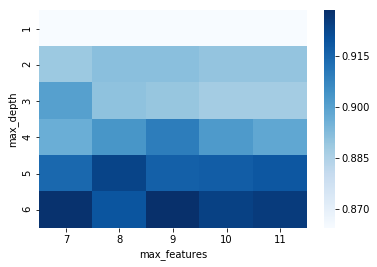

In [15]:
grid_visualization = grid_search.cv_results_.get('mean_test_score')
grid_visualization = np.array(grid_visualization)
grid_visualization.shape = (6, 5)

sb.heatmap(grid_visualization, cmap='Blues')
plt.xticks(np.arange(5) + 0.5, grid_search.param_grid['max_features'])
plt.yticks(np.arange(6) + 0.5, grid_search.param_grid['max_depth'][::1])
plt.xlabel('max_features')
plt.ylabel('max_depth')

Now we have a better sense of the parameter space: a `max_depth > 4` is needed for the decision tree perform reasonably well. Tuning the `max_features` doesn't seem to make as much difference as we achieved the best performance with using `9` out of the 11 features.

An alternative way to visualise the performance of your parameter tuning results is to plot [validation curves](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html).

Let's go ahead and use a broader grid search to find the best settings for more parameters.

In [17]:
# Create a decision tree classifier
dtc = DecisionTreeClassifier(random_state=seed)

# Hyperparameter values to explore
parameter_grid = {'criterion':['gini','entropy'],
                 'splitter': ['best','random'],
                 'max_depth': [4,5,6],
                 'max_features':[7,8,9,10,11],
                 'min_samples_split':[2,4,6,8]}

# Create a cross validation object using StratifiedKFold
skf = StratifiedKFold(n_splits=10, random_state=seed)
cross_validation = skf.split(X_train, y_train)

# Instantiate the grid search using GridSearchCV
grid_search = GridSearchCV(dtc,
                          param_grid = parameter_grid,
                          cv = cross_validation)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Display the best model scores and parameters
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.9311064718162839
Best parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 9, 'min_samples_split': 2, 'splitter': 'best'}


Save the best classifier from the grid search.

In [18]:
dtc = grid_search.best_estimator_
# Examine the model
dtc

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_features=9, max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=19, splitter='best')

Now plot the learning curve for the best classifier for evaluation.

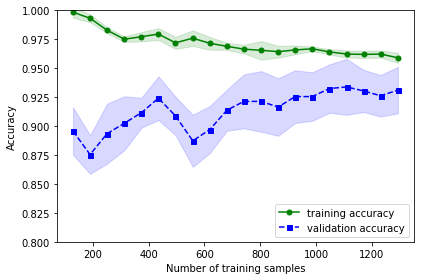

In [19]:
# Generate the learning curve scores
train_sizes, train_scores, val_scores = learning_curve(estimator=dtc,
                                                      X = X_train,
                                                      y = y_train,
                                                      train_sizes = np.linspace(0.1,1,20),
                                                      cv = 10)

# Calculate the result averages and standard deviation
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)


# Plot the training learning curve
plt.plot(train_sizes, train_mean,
         color='green', marker='o',
         markersize=5, label='training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='green')

# Plot the validation learning curve
plt.plot(train_sizes, val_mean,
         color='blue', linestyle='--',
         marker='s', markersize=5,
         label='validation accuracy')

plt.fill_between(train_sizes,
                 val_mean + val_std,
                 val_mean - val_std,
                 alpha=0.15, color='blue')

# Plot settings
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1])
plt.tight_layout()
# plt.savefig('images/learning_curve.png', dpi=300)
plt.show()

This learning curve looks better. The gap between the training and validation accuracy has reduced with training score of 95% and a validation score of 93% which suggests the model is no longer overfitting.

### Reporting
[[ go back to the top ]](#Table-of-contents)

Score the classifier on the test dataset.

In [20]:
# Get the best estimator from the grid search
dtc = grid_search.best_estimator_

# Score the estimator on the test dataset
dtc.score(X_test, y_test)

0.9277777777777778

Our best classifier achieves a test accuracy score of 92.7% which is almost on par with our validation score of 93%. This gives us confidence that our experiment design and trained model is providing realistic results.

We can generate a confusion matrix using the `confusion_matrix` function to get more detailed classification results.

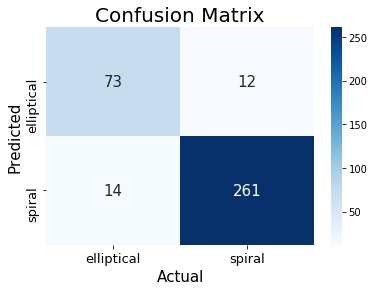

In [21]:
# Import the confusion_matrix function
from sklearn.metrics import confusion_matrix

# Generate the predictions
y_pred = dtc.predict(X_test)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame for plotting
labels = ['elliptical', 'spiral']
df_cm = pd.DataFrame(cm, columns=labels, index=labels)

# Plot the confusion matrix
sb.heatmap(df_cm, annot=True, fmt='g', cmap='Blues', annot_kws={"size": 15})
plt.title('Confusion Matrix', fontsize=20)
plt.xlabel('Actual', fontsize=15)
plt.xticks(fontsize=13)
plt.ylabel('Predicted', fontsize=15)
plt.yticks(fontsize=13)
plt.show()

The confusion matrix provides more detailed information of where the classifier made mistakes (i.e. where it was confused). Here we can see that the model predicted 12 galaxies as spiral that were actually elliptical and 14 elliptical galaxies that were actually spiral. Overall, it looks like the decision tree classifier has performed quite well on test dataset.

We can also visualize the decision tree with [GraphViz](http://www.graphviz.org/) to see how it's making the classifications:

In [22]:
import sklearn.tree as tree
from sklearn.externals.six import StringIO

with open('../media/galaxy_tree.dot', 'w') as out_file:
    out_file = tree.export_graphviz(decision_tree_classifier, out_file=out_file)

In [23]:
# The exported decision tree graph displays features by their index. e.g. X[0], ... X[10]
# This snippet will replace the index names with the actual feature names
replacements = {}
for index, feature in enumerate(features):
    key = 'X[%d]' % (index)
    replacements[key] = feature

with open('../media/galaxy_tree.dot') as infile, open('../media/galaxy_tree_names.dot', 'w') as outfile:
    for line in infile:
        for src, target in replacements.items():
            line = line.replace(src, target)
        outfile.write(line)

If you have [GraphViz](http://www.graphviz.org/) installed then you can generate a image of the decision tree with the following command:

    dot -Tpng images/galaxy_tree_names.dot -o images/galaxy_tree_names.png

<img src="../media/galaxy_tree_names.png" />

Alright! We finally have our demo classifier. Let's create some more visuals of its performance so we have something to put in our report.

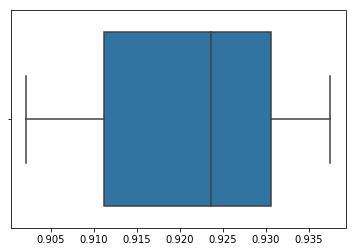

In [24]:
dt_scores = cross_val_score(decision_tree_classifier, X_train, y_train, cv=10)
sb.boxplot(dt_scores)

This plot is not very useful with just one model so let's train another.

A common problem with decision trees is that they're prone to overfitting. They can add complex rules to the point that they classify the training set near-perfectly (as we saw early with our learning curves), but fail to generalise well to data they have not seen before.


**Random Forest classifiers** work around this limitation by creating many decision trees (i.e. a forest), each trained on random subsets of training samples and features. These decision trees are then combined to make a more accurate classification. Let's see if a random forest classifier works better for our datatset. 

The great part about scikit-learn is that the modelling pattern of training, testing, parameter tuning, etc. process is the same for all models. We only need to plug in the new classifier.

In [25]:
# Step 1: Import the class
from sklearn.ensemble import RandomForestClassifier

# Step 2: Instantiate the estimator
random_forest_classifier = RandomForestClassifier(random_state = seed)

# Hyperparameter values to explore
parameter_grid = {'n_estimators':[5,10,25,50],
                 'criterion': ['gini','entropy'],
                 'max_features': [1,2,3,4],
                 'warm_start': [True, False]}

# Create a cross validation object using StratifiedKFold
skf = StratifiedKFold(n_splits=10, random_state=seed)
cross_validation = skf.split(X_train, y_train)

# Instantiate the grid search using GridSearchCV 
grid_search = GridSearchCV(random_forest_classifier,
                          param_grid = parameter_grid,
                          cv = cross_validation)

# Step 3 & 4: Fit the estimator on data (i.e. train the model) and generate predictions
grid_search.fit(X_train, y_train)


# Display the best model scores and parameters
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

grid_search.best_estimator_

Best score: 0.9526791927627001
Best parameters: {'criterion': 'entropy', 'max_features': 4, 'n_estimators': 25, 'warm_start': True}


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=4, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=None,
            oob_score=False, random_state=19, verbose=0, warm_start=True)

The random forest classifier achieved a 95% cross validation accuracy score. Find out how well it performs on the test dataset.

In [26]:
# Get the best estimator from the grid search
random_forest_classifier = grid_search.best_estimator_

# Score the estimator on the test dataset
random_forest_classifier.score(X_test, y_test)

0.9611111111111111

Random forests performs better than the decision tree classifier on the test dataset:

- decision trees ~ 92%
- random forests ~ 96%

We can also plot and compare their cross validation performance.

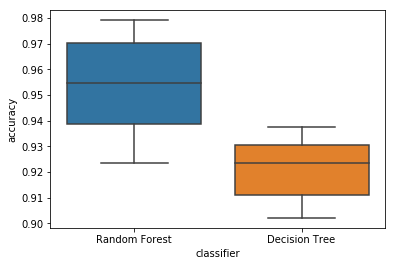

In [27]:
rf_df = pd.DataFrame({'accuracy': cross_val_score(random_forest_classifier, X_train, y_train, cv=10),
                       'classifier': ['Random Forest'] * 10})
dt_df = pd.DataFrame({'accuracy': cross_val_score(decision_tree_classifier, X_train, y_train, cv=10),
                      'classifier': ['Decision Tree'] * 10})
both_df = rf_df.append(dt_df)

sb.boxplot(x='classifier', y='accuracy', data=both_df)

Random forests also performs better on average than decisions trees with cross validation. Random forest classifiers can perform particularly well when there's hundreds of possible features to model (we only have 11 features in dataset). In other words, there was not much room for improvement for random forests over decision trees with this dataset.

To report more detailed information of our model, let's see what features were considered the most important for both classifiers.

In [28]:
# Decision tree features
sorted(zip(dtc.feature_importances_, features), reverse=True)

[(0.46269416133009605, 'stellar_mass'),
 (0.15681121089636116, 'deVAB_r'),
 (0.1405762294448055, 'deVRad_r'),
 (0.12201512638139936, 'expAB_r'),
 (0.052484089510222494, 'redshift'),
 (0.030267625687534775, 'expRad_r'),
 (0.021412290724942117, 'mag_z'),
 (0.013739266024638607, 'mag_r'),
 (0.0, 'mag_u'),
 (0.0, 'mag_i'),
 (0.0, 'mag_g')]

In [29]:
# Random forests features
sorted(zip(random_forest_classifier.feature_importances_, features), reverse=True)

[(0.22982986327267074, 'stellar_mass'),
 (0.15988872036772553, 'deVAB_r'),
 (0.14061628935889348, 'expAB_r'),
 (0.12154504477490677, 'deVRad_r'),
 (0.08207291240614895, 'expRad_r'),
 (0.0806749312512615, 'redshift'),
 (0.05809013342335676, 'mag_z'),
 (0.04409737425845086, 'mag_i'),
 (0.03174041511435401, 'mag_u'),
 (0.02792271322519657, 'mag_g'),
 (0.023521602547034885, 'mag_r')]

Both classifiers rank the importance of the features in a similar order with the exception of the magnitudes. The stellar mass, ellipticity, radius and redshift of the galaxies were the most important features. 

If you want to explore this further you could experiment with removing the `mag_u`, `mag_i`, `mag_g` features as they scored a feature importance of `0` for the decision tree classifier to see how it affects classification performance. Additionally, you can experiment with various [feature selection methods](http://scikit-learn.org/stable/modules/feature_selection.html) for systemtically selecting a reduced feature set.

**see the slides for an explanation of the limitations of the tree classifier**

#### Other algorithms

There are many [classification algorithms](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning) we can experiment with on our dataset. Try fitting a [Logistic Regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), a [Linear Support Vector Classifier (SVM)](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC), or a [Gradient Boosting Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) model on the dataset. It is up to you whether you want to perform parameter tuning on these models. 

Generate boxplots so we can compare the performance with the decision tree and random forest models.

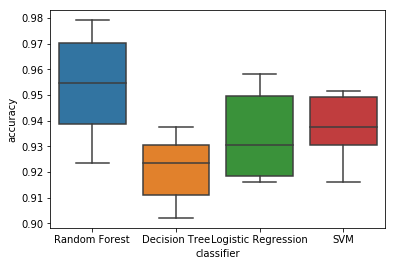

In [30]:
# Import the required models
# Import the required models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

# Initialise the models
lg = LogisticRegression(solver='lbfgs', max_iter=1e4, random_state=seed)
svc = LinearSVC(random_state=seed, max_iter=1e5)

# Calculate the cross validation scores
lg_cv = cross_val_score(lg, X_train, y_train, cv=10)
svc_cv = cross_val_score(svc, X_train, y_train, cv =10)

# Create a DataFrame of the results
lg_df = pd.DataFrame({'accuracy':lg_cv, 'classifier':['Logistic Regression']*10})
svc_df = pd.DataFrame({'accuracy':svc_cv, 'classifier':['SVM']*10})

# Merge all classifier results
classifiers_df = rf_df.append([dt_df, lg_df , svc_df ])

# Generate a box plot comparing the different algorithms
sb.boxplot(x='classifier', y='accuracy', data=classifiers_df)

### Your turn

Pick your favourite model and use it to predict the morphology of galaxies that have been labelled as  uncertain in the dataset. 

- How many spiral vs. elliptical galaxies does the model predict?
- How do the model predictions compare with the debiased labelled probabilities?
- How would you use this model and results in practice? Remember that our original data included many uncertain galaxies, try to predict their type. How do you decide which prediction to use/trust? Can you improve your model for future predictions?